<a href="https://colab.research.google.com/github/williamsun-hha/Google-Colab-LLM/blob/main/Copy_of_LLM_Consortium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Consortium Workflow

Yet another implementation of [Karpathy's tweet](https://x.com/karpathy/status/1869860858006049259), inspired by https://github.com/irthomasthomas/llm-consortium built with [LlamaIndex workflows](https://docs.llamaindex.ai/en/stable/module_guides/workflow/).

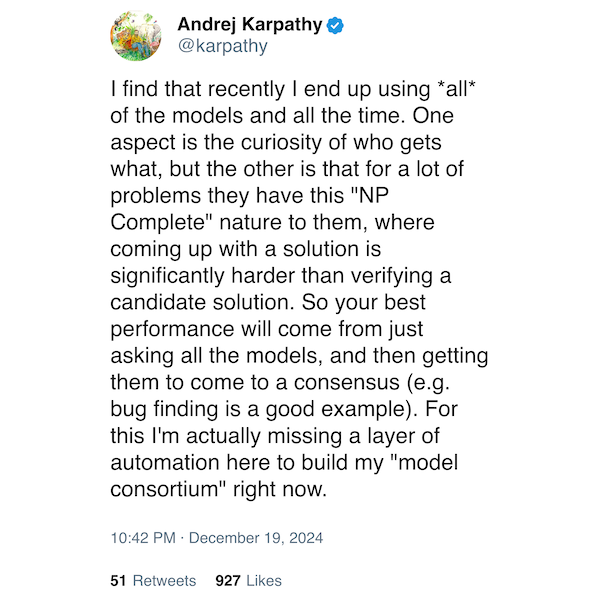

Also part of the stack:
- [Banks](https://github.com/masci/banks) is used for the templating of the various prompts
- [LiteLLM](https://www.litellm.ai/) is used to talk to the different LLM providers in a model-agnostic fashion.

First things first, let's install what we need.



> **Important**! We're going to run Llama3.2 from this notebook, and even if it runs ok on CPU it's better to use a GPU. In Colab, go to "Runtime" -> "Change runtime type" and select one running on GPU.



In [ ]:
!pip install llama-index banks

We're going to use these LLMs:
- `claude-3-haiku` for the arbiter
- `claude-3-5-sonnet`, `gpt-3.5-turbo-1106` and `llama3.2:3b` for the consortium members

The client will need the api keys to talk with the respective LLM providers, we store them in environment variables. I use Colab's secrets (and you should too!) but you can hardcode the values below if you prefer (but you should not!).

In [ ]:
import os
import logging

from google.colab import userdata


os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

logging.basicConfig(
    format='%(levelname)s: %(message)s', level=logging.INFO, force=True
)

To use `llama3.2` we'll need the help of Ollama:

In [ ]:
! apt install pciutils
# Get Ollama
! curl https://ollama.ai/install.sh | sh
# Run it in the background
! nohup ollama serve > ollama.log 2>&1 &

In [ ]:
# Pull the model
! ollama pull llama3.2:3b
# Make sure we're good to go
! ollama list

There are two main abstractions in this application: the Arbiter and the consortium Member, and we need as many dedicated prompts. By using Banks, I can move some if-then-else logic away from Python and into the prompt itself. This way, both the prompts and the Python code should be easier to understand.

In [ ]:
from banks import Prompt


member_prompt = Prompt("""
{% chat role="system" %}
You are part of a model consortium working together to solve complex problems through an iterative process.
Your task is to provide an updated response to a problem, considering previous work and focusing on specific
refinement areas.

Please follow these steps when formulating your response:

1. Begin by carefully considering the specific instructions provided.

2. Write your thought process inside <thought_process> tags. In this section:
   - List key aspects that are relevant to the query
   - Identify potential challenges or limitations
   - Consider how the response instructions affect your approach
   - Explore different angles, consider potential challenges, and explain your logic step-by-step

3. After your thought process, provide your confidence level on a scale from 0 to 1, where 0 represents no confidence and 1 represents absolute certainty. Use <confidence> tags for this.

4. Finally, present your answer within <answer> tags.

Your response should follow this structure:

<thought_process>
[Your detailed thought process, exploring various aspects of the problem]
</thought_process>

<answer>
[Your final, well-considered answer to the query]
</answer>

<confidence>
[Your confidence level from 0 to 1]
</confidence>

Remember to be thorough in your reasoning, clear in your explanations, and precise in your confidence assessment. Your contribution is valuable to the consortium's collaborative problem-solving efforts.
{% endchat %}


{% chat role="user" %}

{% if iteration_number > 1 %}
We need to iterate to reach a consensus among the consortium members.
Review the previous iterations of work on this problem, pay attention to refinement areas:

<previous_iteration>
  <iteration_number>{{ iteration_number }}</iteration_number>
  <synthesis>{{ synthesis }}</synthesis>
  <refinement_areas>{{ refinement_areas }}</refinement_areas>
</previous_iteration>

{% endif %}

This is the original prompt you're addressing:

<original_prompt>{{ original_prompt }}</original_prompt>

{% endchat %}
""")

arbiter_prompt = Prompt("""
{% chat role="system" %}
You are the arbiter of a model consortium working together to solve complex problems through an iterative process.
Your task is to judge the reponses to a problem provided by the members of the consortium, considering previous work
and providing on specific refinement areas.

Please follow these steps to complete your task:

1. Carefully analyze the original prompt, iteration history, and model responses.
2. Extract and list key points from each model response.
3. Compare and contrast the key points from different responses.
4. Evaluate the relevance of each response to the original prompt.
5. Identify areas of agreement and disagreement among the responses.
6. Synthesize a final response that represents the best consensus.
7. Determine your confidence level in the synthesized response.
8. Highlight any important dissenting views.
9. Assess whether further iterations are needed.
10. If further iterations are needed, provide recommendations for refinement areas.

Wrap your thought process inside <thought_process> tags before providing the final output. In your thought process, consider the following questions:
- What are the key points addressed by each model response?
- How do the responses align or differ from each other?
- What are the strengths and weaknesses of each response?
- Are there any unique insights or perspectives offered by specific responses?
- How well does each response address the original prompt?

After your thought process, provide your synthesized output using the following format:

<synthesis>
    [Your synthesized response here. This should be a comprehensive summary that combines the best elements of the analyzed responses while addressing the original prompt effectively.]
</synthesis>

<confidence>
    [Your confidence in this synthesis, expressed as a decimal between 0 and 1. For example, 0.85 would indicate 85% confidence.]
</confidence>

<analysis>
    [A concise summary of your analysis, explaining how you arrived at your synthesized response and confidence level.]
</analysis>

<dissent>
    [List any notable dissenting views or alternative perspectives that were not incorporated into the main synthesis but are still worth considering.]
</dissent>

<needs_iteration>
    [Indicate whether further iteration is needed. Use "true" if more refinement is necessary, or "false" if the current synthesis is sufficient.]
</needs_iteration>

<refinement_areas>
    [If needs_iteration is true, provide a list of specific areas or aspects that require further refinement or exploration in subsequent iterations.]
</refinement_areas>


Remember to maintain objectivity and consider all perspectives fairly in your analysis and synthesis. Your goal is to provide a comprehensive and balanced response that accurately represents the collective insights from the model responses while addressing the original prompt effectively.
{% endchat %}

{% chat role="user" %}
<original_prompt>{{ original_prompt }}</original_prompt>

<model_responses>
  {% for model, response in responses.items() %}
    {% set tp, answer, confidence = response %}
    <model_response>
      <model>{{ model }}</model>
      <confidence>{{ confidence }}</confidence>
      <response>{{ answer }}</response>
    </model_response>
  {% endfor %}
</model_responses>
{% endchat %}
""")



Time to define the application logic. By using a LlamaIndex workflow we get some nifty features out of the box:
- The orchestration part is very compact (less than 150 lines of code, imports included) and isolated from the prompting logic.
- The application is natively async, and the consortium operates concurrently.
- It's not used within this notebook, but LlamaIndex workflows are instrumented by default and we could potentially plug [any supported observability provider](https://docs.llamaindex.ai/en/stable/module_guides/observability/) with no code changes.

Before getting to the code, let's take a bird's-eye view of the steps composing this workflow:
- The `begin()` step is called when the consortium members need to answer a question. This can happen the first time when the workflow starts obviously, but also when the consortium arbiter decides that the answers need another iteration. This is why you see the step consumes two different types of event, `StartEvent` and `IterationNeeded`.
- The `ask_member()` is a generic step with the sole purpose of querying an LLM and return its response. It's where concurrency is more obviously beneficial, because this step can operate multiple LLMs asynchronously.
- The `collect_responses()` step is responsible for collecting all the responses from the various member of the consortium and ensure all the members have responded. Only then it will proceed invoking the arbiter.
- The `ask_arbiter()` step is where the arbiter is invoked with a prompt containing all the responses from the consortium members. The arbiter will reason on those responses and decide whether we're done, exiting the workflow with a synthesis of the responses, or ask the consortium again going back to `begin()`, where the prompt this time will be enriched with directions on improvement areas.

In [ ]:
import logging
import re

from llama_index.core.workflow import (
    Workflow,
    step,
    StartEvent,
    StopEvent,
    Context,
    Event,
)
from litellm import acompletion
from banks import Prompt


class ResponseNeeded(Event):
  """This event is sent when a member of the consortium needs to answer the query."""
  messages: list
  model: str


class MemberAnswered(Event):
  """This event is sent when a member of the consortium has answered the query."""
  response: str
  member: str


class ArbiterNeeded(Event):
  """This event is sent when all the members have answered and it's time to reach out to the arbiter."""
  pass


class IterationNeeded(Event):
  """This event is sent by the arbiter when it needs to iterate."""
  synthesis: str
  refinement_areas: str



class Consortium(Workflow):
  def __init__(self, *, max_iterations: int=3, members: list[str] | None=None, arbiter: str | None=None, **kwargs):
    super().__init__(**kwargs)
    self._members = members or ["anthropic/claude-3-5-sonnet-20240620", "openai/gpt-3.5-turbo-1106", "ollama/llama3.2:3b"]
    self._arbiter = arbiter or "anthropic/claude-3-haiku-20240307"
    self._max_iterations = 3

  @step
  async def begin(self, ev: StartEvent | IterationNeeded, ctx: Context) -> None:
    if isinstance(ev, StartEvent):
      logging.info("Summoning the consortium...")

      # Store the current iteration number and the original prompt in the context, we'll need them later
      await ctx.set("iterations", 1)
      await ctx.set("original_prompt", ev.query)

      # Render the chat messages for the consortium members prompt template
      chat_messages = member_prompt.chat_messages({"iteration_number": 1, "original_prompt": ev.query})
    else:
      iteration_number = await ctx.get("iterations")
      logging.info("Asking the consortium to iterate, step %s", iteration_number)
      chat_messages = member_prompt.chat_messages({
          "iteration_number": iteration_number,
          "original_prompt": await ctx.get("original_prompt"),
          "refinement_areas": ev.refinement_areas,
          "synthesis": ev.synthesis
      })

    # Ask the consortium members to answer the query
    for model in self._members:
      # Convert the objects of type ChatMessage into dictionaries before sending the request to the LLM
      logging.info("Asking %s to answer the query...", model)
      ctx.send_event(ResponseNeeded(model=model, messages=[m.model_dump() for m in chat_messages]))

    # This step is done, let the workflow continue
    return None

  @step
  async def ask_member(self, ctx: Context, ev: ResponseNeeded) -> MemberAnswered:
    # Prompt a member of the consortium
    model = ev.model
    logging.info("%s about to answer the query", model)
    response = await acompletion(model=model, messages=ev.messages)
    logging.info("%s answered the query", model)
    # Send out an event containing the response
    return MemberAnswered(response=response.choices[0].message.content, member=model)

  @step
  async def collect_responses(self, ctx: Context, ev: MemberAnswered) -> MemberAnswered | None:
    # Parse a model response
    response = ev.response
    tp = re.search(r"<thought_process>((?s:.)*)<\/thought_process>", response).groups()[0].strip()
    answer = re.search(r"<answer>((?s:.)*)<\/answer>", response).groups()[0].strip()
    confidence = re.search(r"<confidence>((?s:.)*)<\/confidence>", response).groups()[0].strip()

    # Store the parsed response in the context as a tuple
    responses = await ctx.get("responses", {})
    responses[ev.member] = (tp, answer, confidence)
    await ctx.set("responses", responses)

    # If we got a response for every member of the consortium, it's time to reach out to the arbiter.
    if len(responses) == len(self._members):
      # The arbiter will find in the context all the data it needs, so we just send an empty event.
      logging.info("All the memebers have answered, evoking the arbiter...")
      return ArbiterNeeded()

    # Otherwise, keep waiting for all the responses, let the workflow continue
    logging.info("Waiting for all the members to respond...")
    return None

  @step
  async def ask_arbiter(self, ctx: Context, ev: ArbiterNeeded) -> StopEvent | IterationNeeded:
    # Get current number of iterations
    cur_it = await ctx.get("iterations")

    # Exit if we reached the maximum number of iterations allowed
    if cur_it >= self._max_iterations:
      return StopEvent(result="Consortium didn't reach an agreement, check logs for details.")

    # Render the arbiter prompt
    chat_messages = arbiter_prompt.chat_messages({
        "original_prompt": await ctx.get("original_prompt"),
        "responses": await ctx.get("responses", {})
    })
    response = await acompletion(model=self._arbiter, messages=[m.model_dump() for m in chat_messages])

    # Parse the arbiter response
    response = response.choices[0].message.content
    synthesis = re.search(r"<synthesis>((?s:.)*)<\/synthesis>", response).groups()[0].strip()
    confidence = re.search(r"<confidence>((?s:.)*)<\/confidence>", response).groups()[0].strip()
    analysis = re.search(r"<analysis>((?s:.)*)<\/analysis>", response).groups()[0].strip()
    dissent = re.search(r"<dissent>((?s:.)*)<\/dissent>", response).groups()[0].strip()
    logging.info("Dissent areas: %s", dissent)
    needs_iteration = re.search(r"<needs_iteration>((?s:.)*)<\/needs_iteration>", response).groups()[0].strip()
    refinement_areas = re.search(r"<refinement_areas>((?s:.)*)<\/refinement_areas>", response).groups()[0].strip()

    # If we need to iterate, start over using an iteration prompt
    if needs_iteration.strip().lower() == "true":
      logging.info("The arbiter has confidence %s and wants to iterate, starting over...", confidence)
      logging.info("Refinement areas: %s", refinement_areas)
      # Increment the iterations number
      await ctx.set("iterations", cur_it + 1)
      # Trigger the begin() step again
      return IterationNeeded(synthesis=synthesis, refinement_areas=refinement_areas)

    # The arbiter thinks we're done, exit the workflow and return the answer
    logging.info("The arbiter has confidence %s and provided the final answer, exiting the workflow...", confidence)
    return StopEvent(result=synthesis)


To invoke the consortium we can simply run the workflow passing our query:

In [ ]:
c = Consortium(disable_validation=True, timeout=None)
response = await c.run(query="What are the three top reasons to invest time in paying technical debt in software projects?")

INFO: Summoning the consortium...
INFO: Asking anthropic/claude-3-5-sonnet-20240620 to answer the query...
INFO: Asking openai/gpt-3.5-turbo-1106 to answer the query...
INFO: Asking ollama/llama3.2:3b to answer the query...
INFO: anthropic/claude-3-5-sonnet-20240620 about to answer the query
INFO: openai/gpt-3.5-turbo-1106 about to answer the query
INFO: ollama/llama3.2:3b about to answer the query
15:55:17 - LiteLLM:INFO: utils.py:2757 - 
LiteLLM completion() model= gpt-3.5-turbo-1106; provider = openai
INFO: 
LiteLLM completion() model= gpt-3.5-turbo-1106; provider = openai
15:55:17 - LiteLLM:INFO: utils.py:2757 - 
LiteLLM completion() model= claude-3-5-sonnet-20240620; provider = anthropic
15:55:17 - LiteLLM:INFO: utils.py:2757 - 
LiteLLM completion() model= llama3.2:3b; provider = ollama
INFO: 
LiteLLM completion() model= claude-3-5-sonnet-20240620; provider = anthropic
INFO: 
LiteLLM completion() model= llama3.2:3b; provider = ollama
INFO: HTTP Request: POST https://api.openai.com

In [ ]:
print(response)

Based on the analysis of the model responses, the three top reasons to invest time in paying technical debt in software projects are:

1. Improved Maintainability and Extensibility: Addressing technical debt leads to cleaner, more organized codebases that are easier to understand and maintain. This allows for more efficient future development, bug fixes, and feature additions, contributing to a more agile and responsive development process.

2. Enhanced Quality, Reliability, and Reduced Rework: Paying down technical debt improves overall software quality, reduces defects, and increases reliability. This results in a better user experience, increased customer satisfaction, and a more competitive product in the market. Addressing technical debt also leads to a decrease in rework, as teams spend less time working around legacy issues.

3. Long-Term Cost Savings and Improved Team Productivity: Proactively addressing technical debt leads to substantial long-term cost savings by reducing the